In [104]:
from mtcnn import MTCNN
from PIL import Image
import cv2
from matplotlib.pyplot import imshow

import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt

In [110]:
def crop_face(path, export):
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    detector = MTCNN()
    result = detector.detect_faces(image)
    bounding_box = result[0]['box']
    keypoints = result[0]['keypoints']
    
    pil_im = Image.open(path)

    crop_im = pil_im.crop((bounding_box[0], bounding_box[1],bounding_box[0]+ bounding_box[2], bounding_box[1] + bounding_box[3] ))
    crop_im.save(export)
def extractSkin(image):
  # Taking a copy of the image
  img =  image.copy()
  # Converting from BGR Colours Space to HSV
  img =  cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  
  # Defining HSV Threadholds
  lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
  upper_threshold = np.array([20, 255, 255], dtype=np.uint8)
  
  # Single Channel mask,denoting presence of colours in the about threshold
  skinMask = cv2.inRange(img,lower_threshold,upper_threshold)
  
  # Cleaning up mask using Gaussian Filter
  skinMask = cv2.GaussianBlur(skinMask,(3,3),0)
  
  # Extracting skin from the threshold mask
  skin = cv2.bitwise_and(img,img,mask=skinMask)
  
  # Return the Skin image
  return cv2.cvtColor(skin,cv2.COLOR_HSV2BGR)

def removeBlack(estimator_labels, estimator_cluster):
  
  
  # Check for black
  hasBlack = False
  
  # Get the total number of occurance for each color
  occurance_counter = Counter(estimator_labels)

  
  # Quick lambda function to compare to lists
  compare = lambda x, y: Counter(x) == Counter(y)
   
  # Loop through the most common occuring color
  for x in occurance_counter.most_common(len(estimator_cluster)):
    
    # Quick List comprehension to convert each of RBG Numbers to int
    color = [int(i) for i in estimator_cluster[x[0]].tolist() ]
    
  
    
    # Check if the color is [0,0,0] that if it is black 
    if compare(color , [0,0,0]) == True:
      # delete the occurance
      del occurance_counter[x[0]]
      # remove the cluster 
      hasBlack = True
      estimator_cluster = np.delete(estimator_cluster,x[0],0)
      break
      
   
  return (occurance_counter,estimator_cluster,hasBlack)

def getColorInformation(estimator_labels, estimator_cluster,hasThresholding=False):
  
  # Variable to keep count of the occurance of each color predicted
  occurance_counter = None
  
  # Output list variable to return
  colorInformation = []
  
  
  #Check for Black
  hasBlack =False
  
  # If a mask has be applied, remove th black
  if hasThresholding == True:
    
    (occurance,cluster,black) = removeBlack(estimator_labels,estimator_cluster)
    occurance_counter =  occurance
    estimator_cluster = cluster
    hasBlack = black
    
  else:
    occurance_counter = Counter(estimator_labels)
 
  # Get the total sum of all the predicted occurances
  totalOccurance = sum(occurance_counter.values()) 
  
 
  # Loop through all the predicted colors
  for x in occurance_counter.most_common(len(estimator_cluster)):
    
    index = (int(x[0]))
    
    # Quick fix for index out of bound when there is no threshold
    index =  (index-1) if ((hasThresholding & hasBlack)& (int(index) !=0)) else index
    
    # Get the color number into a list
    color = estimator_cluster[index].tolist()
    
    # Get the percentage of each color
    color_percentage= (x[1]/totalOccurance)
    
    #make the dictionay of the information
    colorInfo = {"cluster_index":index , "color": color , "color_percentage" : color_percentage }
    
    # Add the dictionary to the list
    colorInformation.append(colorInfo)
    
      
  return colorInformation 

def extractDominantColor(image,number_of_colors=5,hasThresholding=False):
  
  # Quick Fix Increase cluster counter to neglect the black(Read Article) 
  if hasThresholding == True:
    number_of_colors +=1
  
  # Taking Copy of the image
  img = image.copy()
  
  # Convert Image into RGB Colours Space
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  
  # Reshape Image
  img = img.reshape((img.shape[0]*img.shape[1]) , 3)
  
  #Initiate KMeans Object
  estimator = KMeans(n_clusters=number_of_colors, random_state=0)
  
  # Fit the image
  estimator.fit(img)
  
  # Get Colour Information
  colorInformation = getColorInformation(estimator.labels_,estimator.cluster_centers_,hasThresholding)
  return colorInformation
  
    
def plotColorBar(colorInformation):
  #Create a 500x100 black image
  color_bar = np.zeros((100,500,3), dtype="uint8")
  
  top_x = 0
  for x in colorInformation:    
    bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

    color = tuple(map(int,(x['color'])))
  
    cv2.rectangle(color_bar , (int(top_x),0) , (int(bottom_x),color_bar.shape[0]) ,color , -1)
    top_x = bottom_x
  return color_bar

def prety_print_data(color_info):
  for x in color_info:
    print(pprint.pformat(x))
    print()

In [213]:
im1 = "dataset/taylorswift_1.jpg"
im2 = "dataset/idriselba_1.jpg"
source = "output_1.jpg"
dest = "output_2.jpg"
crop_face(im1, source)
crop_face(im2, dest)


3/3 [==============================] - 0s 18ms/step


In [217]:

source_im=cv2.imread("output_1.jpg")
# Resize image to a width of 250
source_im = imutils.resize(source_im,width=250)
source_skin = extractSkin(source_im)

dest_im=cv2.imread("output_2.jpg")
# Resize image to a width of 250
dest_im = imutils.resize(dest_im,width=250)
dest_skin = extractSkin(dest_im)

# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors 
dominantColors_source = extractDominantColor(source_skin,hasThresholding=True, number_of_colors=4)
dominantColors_dest = extractDominantColor(dest_skin,hasThresholding=True, number_of_colors=4)

dest_rgb = []
for c in dominantColors_dest:
    rgb = (int(c['color'][2]), int(c['color'][1]), int(c['color'][0]))
    dest_rgb.append(rgb)


source_rgb = []
for c in dominantColors_source:
    rgb = (int(c['color'][2]), int(c['color'][1]), int(c['color'][0]))
    source_rgb.append(rgb)
    
print(len(source_rgb))
print(len(dest_rgb))

5
4


source:  (181, 201, 247)
dest:  (74, 89, 129)
source:  (149, 169, 217)
dest:  (55, 63, 90)
source:  (104, 123, 175)
dest:  (95, 116, 171)
source:  (50, 66, 116)
dest:  (126, 146, 203)


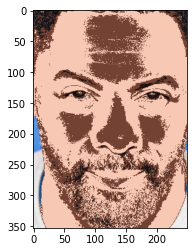

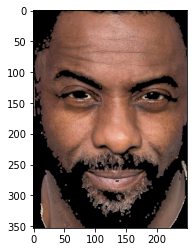

In [221]:
match = 50


final = dest_im.copy()
for x in range(len(dest_rgb)):
    print("source: ", source_rgb[x])
    print("dest: ", dest_rgb[x])
    for i, row in enumerate(final):
      # get the pixel values by iterating
        for j, pixel in enumerate(final):
            
            if( i < 353 and j < 250):
                rgb_compare = (final[i][j][0], final[i][j][1], final[i][j][2])
                diff1 = rgb_compare[0] - dest_rgb[x][0]
                diff2 = rgb_compare[1] - dest_rgb[x][1]
                diff3 = rgb_compare[2] - dest_rgb[x][2]
                #print(abs(diff3), abs(diff2), abs(diff1))
#                 if(abs(diff1) < 20):
#                     print(rgb_compare[0], dest_rgb[x][0])
#                     print("diff 1 match for ", rgb_compare)
#                 if(abs(diff2) < 20):
#                     print("diff 2 match for ", rgb_compare)
#                 if(abs(diff3) < 20):
#                     print("diff 3 match for ", rgb_compare)
                if((abs(diff1) < match) and (abs(diff2) < match) and (abs(diff3) < match)):
                    final[i][j] = source_rgb[x]
#                 picture.putpixel((x,y), source_rgb[x])

plt.imshow(cv2.cvtColor(final,cv2.COLOR_BGR2RGB))
plt.show()

# showcase=cv2.imread("output_2.jpg")
plt.imshow(cv2.cvtColor(dest_skin,cv2.COLOR_BGR2RGB))
plt.show()

In [108]:

# crop_im.show()